In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
%matplotlib inline
ox.config(log_file=False, log_console=True, use_cache=False)

In [4]:
# Load geometries in shapefile format
neigh = gpd.read_file('../Barrio_Vereda/Med_neighborhoods_utm.shp')
sitz  = gpd.read_file('../EOD_2017/SITzones_utm.shp')
print(neigh.head())
print(sitz.head())

  CODIGO                    NOMBRE  area_neigh  Id_neigh  \
0   1422             La Aguacatala  621794.001         0   
1   0810                  El Pinal  413220.712         1   
2   0719              Fuente Clara  236329.304         2   
3   0102  Santo Domingo Savio No.2  264625.437         3   
4   0302               Las Granjas  641045.834         4   

                                            geometry  
0  POLYGON ((436250.758566929 684753.1652246107, ...  
1  POLYGON ((440086.8269772817 690353.6293147943,...  
2  POLYGON ((433513.2601061059 694009.4078272607,...  
3  POLYGON ((440202.7038027243 696660.8769311687,...  
4  POLYGON ((439858.0616223979 694481.7332515356,...  
  Name            desc2  area_ha   area_sitz  Id_sitz  \
0    1  Medellin urbano   26.452  264523.223        1   
1   10  Medellin urbano    6.738   67382.145       10   
2  100  Medellin urbano   41.420  414201.992      100   
3  101  Medellin urbano   39.840  398402.046      101   
4  102  Medellin urbano 

In [6]:
# check original projection - CRS
print('neighborhoods CRS: ', neigh.crs)
print('SIT zones CRS: ', sitz.crs)

neighborhoods CRS:  {'init': 'epsg:32618'}
SIT zones CRS:  {'init': 'epsg:32618'}


In [7]:
# change CRS to WGS 84
neigh = neigh.to_crs({'init': 'epsg:4326'})
sitz = sitz.to_crs({'init': 'epsg:4326'})

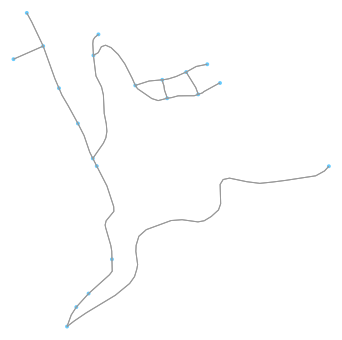

In [8]:
# test network for defined region
reg1 = neigh[(neigh['CODIGO']=='0102')]
pol1 = reg1['geometry'].iloc[0]
G1 = ox.graph_from_polygon(pol1, network_type='drive_service')
fig, ax = ox.plot_graph(G1)

In [9]:
# calc basic network metrics

# area of polygon
area = ox.project_gdf(reg1).area
stats = ox.basic_stats(G1, area=area)

# display stats
for key, value in stats.items():
    stats[key] = value
print(pd.Series(stats))
print("area (km2) = ", area.iloc[0]/1000000)

circuity_avg                                                               1.08039
clean_intersection_count                                                      None
clean_intersection_density_km                                                 None
edge_density_km                                   3    18819.854422
dtype: float64
edge_length_avg                                                            113.106
edge_length_total                                                          4976.67
intersection_count                                                              17
intersection_density_km                              3    64.287496
dtype: float64
k_avg                                                                      4.19048
m                                                                               44
n                                                                               21
node_density_km                                      3    79.413966
dtype: float64
self

In [10]:
# average circuity
stats['circuity_avg']

1.0803887802801588

In [11]:
# intersection density
stats['intersection_density_km'].iloc[0]

64.28749620815489

In [12]:
# average node degree, k_avg
# Mean number of inbound and outbound edges incident to the nodes
stats['k_avg']

4.190476190476191

In [17]:
# test de loop
for p in neigh['CODIGO']:
    try:
        #select polygon
        region = neigh[neigh['CODIGO']==p]
        #define polygon boundary
        pol = region['geometry'].iloc[0].buffer(20)
        #area = ox.project_gdf(pol).area
        area = ox.project_gdf(region).area
        print(p, "area=", area.iloc[0])
    except:
        print("error")

1422 area= 621359.4923159962
0810 area= 412927.4451405634
0719 area= 236166.49821386658
0102 area= 264437.11456666666
0302 area= 640591.5111142397
0902 area= 441710.68702951685
Inst_16 area= 316087.6126667782
1008 area= 329852.41455694684
0907 area= 292818.3921116833
0501 area= 289712.5682517533
1203 area= 232726.1270240125
0911 area= 248831.00860490886
1609 area= 461580.8797648591
0806 area= 320177.610544533
0913 area= 666209.4469559327
0609 area= 123586.23655416742
1212 area= 317290.52480360935
0513 area= 232791.54528204404
1608 area= 507647.4391361086
1315 area= 223978.55382785815
1204 area= 358024.2162538052
0415 area= 230107.1887370112
Inst_14 area= 417308.58546519745
1421 area= 728199.4797210069
1413 area= 660256.8217087628
1618 area= 188379.99397538166
0207 area= 229357.25091628425
0811 area= 173696.141209159
0602 area= 435772.115328307
1611 area= 484468.84487091174
0901 area= 74957.96269564233
0715 area= 250486.49622513316
1502 area= 230293.3574507877
0308 area= 372850.44496615

In [19]:
# OSMnx selected metrics by neighborhood

# archivo de salida
fout = open("../metrics/7_OSM_metrics_neigh.csv","w")
line = "CODIGO,circuity_avg,street_density_km,int_dens_km,k_avg" + "\n"
fout.write(line)

for p in neigh['CODIGO']:
    try:
        #select polygon (analytic region)
        region = neigh[neigh['CODIGO']==p]
        #define polygon boundary
        pol = region['geometry'].iloc[0]
        #get OSM street network - drive roads
        G = ox.graph_from_polygon(pol, network_type='drive_service')
        #calculate basic network metrics
        area = ox.project_gdf(region).area
        stats = ox.basic_stats(G, area=area)
        line = str(p) +","+str(stats['circuity_avg'])+","+str(stats['street_density_km'].iloc[0])+","+str(stats['intersection_density_km'].iloc[0])+","+str(stats['k_avg'])+ "\n"
        fout.write(line)
    except:
        line = str(p) +","+"ERROR EN EJECUCION"+ "\n"
        fout.write(line)        
fout.close()

In [ ]:
# OSMnx selected metrics by SITzones - not run

# archivo de salida
fout = open("../metrics/8_OSM_metrics_SITzones.csv","w")
line = "Id_sitz | circuity_avg | street_density_km | int_dens_km | k_avg" + "\n"
fout.write(line)

for p in sitz['Id_sitz']:
    try:
        #select polygon (analytic region)
        region = sitz[sitz['Id_sitz']==p]
        #define polygon boundary
        pol = region['geometry'].iloc[0]
        #get OSM street network - drive roads
        G = ox.graph_from_polygon(pol, network_type='drive_service')
        #calculate basic network metrics
        area = ox.project_gdf(region).area
        stats = ox.basic_stats(G, area=area)
        line = str(p) +"|"+str(stats['circuity_avg'])+"|"+str(stats['street_density_km'].iloc[0])+"|"+str(stats['intersection_density_km'].iloc[0])+"|"+str(stats['k_avg'])+ "\n"
        fout.write(line)
    except:
        line = str(p) +"|"+"ERROR EN EJECUCION"+ "\n"
        fout.write(line)        
fout.close()